In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
from torch import optim
from torchvision import models
from torchvision.utils import make_grid

from datasets import ITSDataset, DomainDataset
from gan.utils import CycleGANConfig, save_checkpoint, load_checkpoint, display_images
from gan.generator import Generator
from gan.discriminator import Discriminator
from gan.trainer import PerceptualLoss, train, get_cycle_gan_trainer

In [3]:
config = CycleGANConfig(
    "../../commons/datasets/its/",
    "HazeGan",
    "v1",
    image_shape=(3, 56, 56),
    latent_dim=64,
    epochs=1, batch_size=4,
    lr=2e-4,
    betas=(0.5, 0.999),
    lambdas=(10, 0.5),
    residuals=9,
    blocks=(64, 128, 256, 512)
)

In [4]:
ds = DomainDataset(
    ITSDataset(config.dataset_path, SET="hazy", download=True, img_transform=config.transforms, sub_sample=0.25),
    ITSDataset(config.dataset_path, SET="clear", download=True, img_transform=config.transforms, sub_sample=1)
).to(config.device)

In [19]:
generator_A = Generator(config.image_shape[0], config.latent_dim, config.residuals).to(config.device)
generator_B = Generator(config.image_shape[0], config.latent_dim, config.residuals).to(config.device)
discriminator_A = Discriminator(config.image_shape[0], list(config.blocks)).to(config.device)
discriminator_B = Discriminator(config.image_shape[0], list(config.blocks)).to(config.device)
optimizer_G = optim.Adam(
    list(generator_A.parameters()) + list(generator_B.parameters()),
    lr=config.lr,
    betas=config.betas
)
optimizer_D = optim.Adam(
    list(discriminator_A.parameters()) + list(discriminator_B.parameters()),
    lr=config.lr,
    betas=config.betas
)

In [6]:
perceptual_model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:35].to(config.device)
perceptual_loss = PerceptualLoss(perceptual_model)
fixed_A, fixed_B = ds[:4].values()
trainer = get_cycle_gan_trainer(generator_A, generator_B, discriminator_A, discriminator_B, optimizer_G, optimizer_D,
                                perceptual_loss=perceptual_loss, lambda_cycle=config.lambdas[0],
                                lambda_identity=config.lambdas[1],
                                writer=config.writer, period=1,
                                fixed_A=fixed_A, fixed_B=fixed_B)

In [ ]:
file_name = "*.pt"
others = load_checkpoint(
    f"{config.checkpoint_path}/{file_name}",
    {"generator_A": generator_A, "generator_B": generator_B, "discriminator_A": discriminator_A, "discriminator_B": discriminator_B},
    {"optimizer_G": optimizer_G, "optimizer_D": optimizer_D},
)

In [ ]:
train(
    trainer, ds,
    ne=config.epochs, bs=config.batch_size,
)

In [ ]:
save_checkpoint(
    config.checkpoint_path,
    {"generator_A": generator_A, "generator_B": generator_B, "discriminator_A": discriminator_A, "discriminator_B": discriminator_B},
    {"optimizer_G": optimizer_G, "optimizer_D": optimizer_D},
)

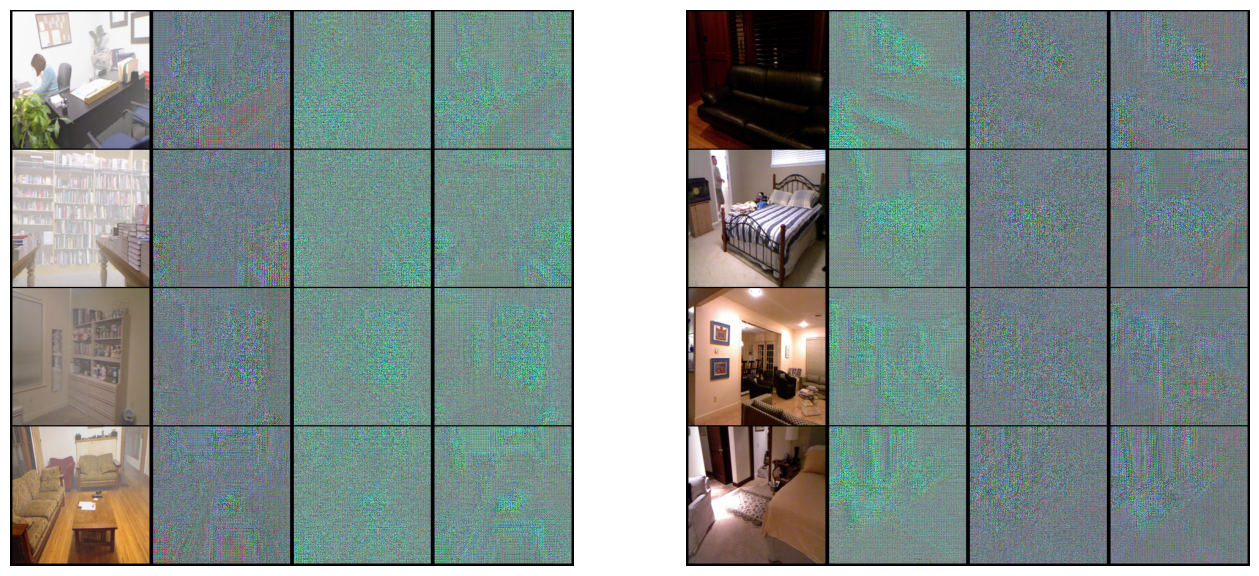

In [36]:
with torch.inference_mode():
    grid_real_A = make_grid(fixed_A, nrow=1, normalize=True)
    grid_real_B = make_grid(fixed_B, nrow=1, normalize=True)
    grid_fake_A = make_grid(fake_A := generator_A(fixed_B), nrow=1, normalize=True)
    grid_fake_B = make_grid(fake_B := generator_B(fixed_A), nrow=1, normalize=True)
    grid_cycle_A = make_grid(generator_A(fake_B), nrow=1, normalize=True)
    grid_cycle_B = make_grid(generator_B(fake_A), nrow=1, normalize=True)
    grid_identity_A = make_grid(generator_A(fixed_A), nrow=1, normalize=True)
    grid_identity_B = make_grid(generator_B(fixed_B), nrow=1, normalize=True)
    grid_A = make_grid(torch.stack([grid_real_A, grid_fake_B, grid_cycle_A, grid_identity_A]), nrow=4, normalize=True)
    grid_B = make_grid(torch.stack([grid_real_B, grid_fake_A, grid_cycle_B, grid_identity_B]), nrow=4, normalize=True)
display_images(torch.stack([grid_A, grid_B]).permute(0, 2, 3, 1))